In [5]:
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import f1_score, classification_report, accuracy_score, confusion_matrix

from sklearn.pipeline import Pipeline

# Load datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39211 entries, 0 to 39210
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   last contact date  39211 non-null  object
 1   age                39211 non-null  int64 
 2   job                38982 non-null  object
 3   marital            39211 non-null  object
 4   education          37744 non-null  object
 5   default            39211 non-null  object
 6   balance            39211 non-null  int64 
 7   housing            39211 non-null  object
 8   loan               39211 non-null  object
 9   contact            28875 non-null  object
 10  duration           39211 non-null  int64 
 11  campaign           39211 non-null  int64 
 12  pdays              39211 non-null  int64 
 13  previous           39211 non-null  int64 
 14  poutcome           9760 non-null   object
 15  target             39211 non-null  object
dtypes: int64(6), object(10)

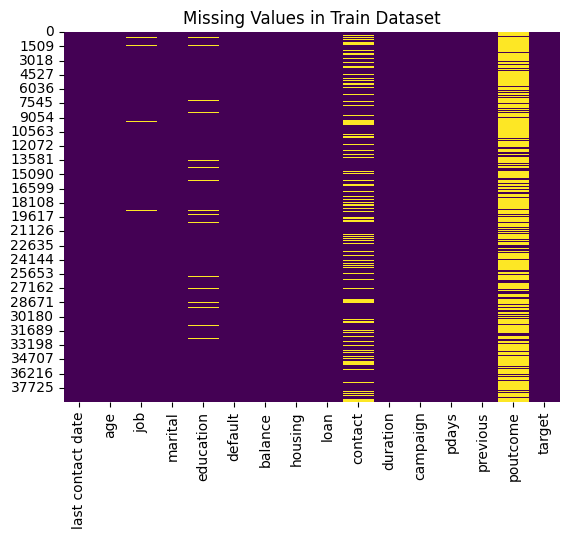

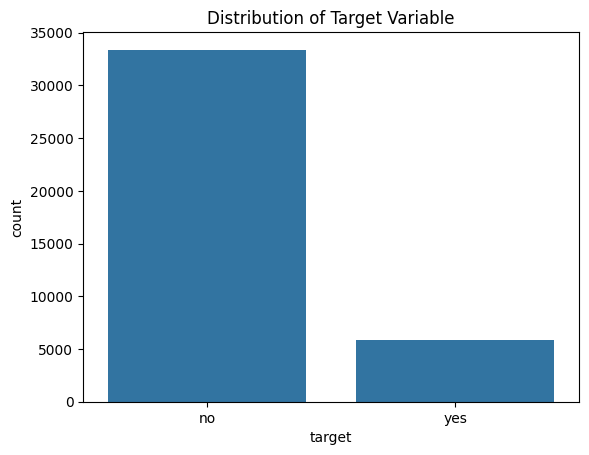

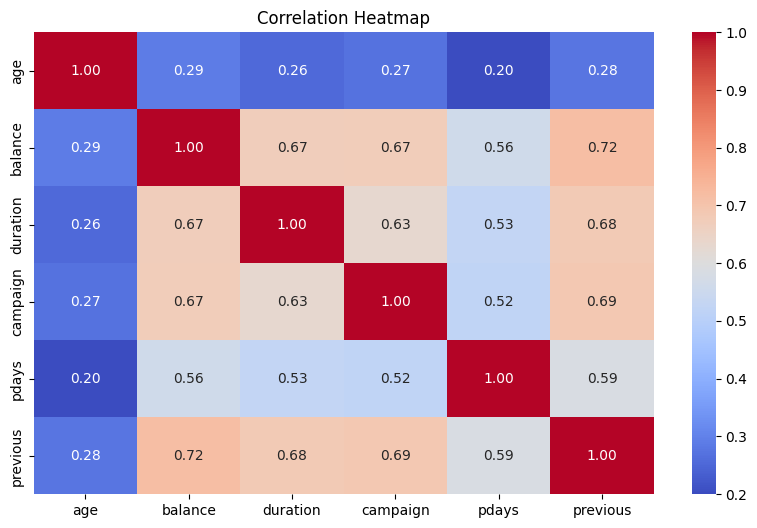

In [2]:
    #EDA and insights
    stats = train.describe()
    print("Train Data Info:")
    print(train.info())
    print("\nTest Data Info:")
    print(test.info())

    #checking missing values to determine how wwe handle it: remove rows for small number of values, or impute for larger quantities

    print("\nMissing Values in Train:")
    print(train.isnull().sum())
    print("\nMissing Values in Test:")
    print(test.isnull().sum())

    # Plot missing values heatmap to see the inconsistency with fequency or distribution of missing values

    sns.heatmap(train.isnull(), cbar=False, cmap="viridis")
    plt.title("Missing Values in Train Dataset")
    plt.show()


    # countplot for target variable to check if it is imbalanced

    sns.countplot(data=train, x='target')
    plt.title("Distribution of Target Variable")
    plt.show()

    # Correlation heatmap for numerical features to check strong and weak correlating features

    numerical_columns = train.select_dtypes(include=["number"]) # Selecting only numerical columns from the train dataset

    if not numerical_columns.empty:   #checking if numerical columns aren't empty
        plt.figure(figsize=(10, 6))
        sns.heatmap(numerical_columns.corr(), annot=True, cmap="coolwarm", fmt=".2f")
        plt.title("Correlation Heatmap")
        plt.show()
    else:
        print("No numerical columns found for correlation heatmap.")

In [2]:
# Fill missing values (similar to other models)
train.fillna(train.median(numeric_only=True), inplace=True)
test.fillna(test.median(numeric_only=True), inplace=True)

for col in train.select_dtypes(include='object').columns:
    train[col].fillna(train[col].mode()[0], inplace=True)
    if col in test.columns:
        test[col].fillna(test[col].mode()[0], inplace=True)

# Encode target and categorical features
y_train = train['target'].apply(lambda x: 1 if x == 'yes' else 0)
X_train = train.drop(['target'], axis=1)

label_encoders = {}
for col in X_train.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    if col in test.columns:
        test[col] = test[col].map(lambda s: le.classes_.tolist().index(s) if s in le.classes_ else -1)
    label_encoders[col] = le

/tmp/ipykernel_7548/58374285.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train[col].fillna(train[col].mode()[0], inplace=True)
/tmp/ipykernel_7548/58374285.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try

In [ ]:
# Split train data
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# LightGBM Classifier with Hyperparameter Tuning
lgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 6, -1],  # -1 means no limit
}

grid_search_lgb = GridSearchCV(
    estimator=LGBMClassifier(random_state=42),
    param_grid=lgb_param_grid,
    scoring='f1_macro',
    cv=3,
    verbose=1
)

grid_search_lgb.fit(X_train_split, y_train_split)

# Best LightGBM Model
best_lgb_model = grid_search_lgb.best_estimator_
print(f"Best Parameters for LightGBM: {grid_search_lgb.best_params_}")

[LightGBM] [Info] Number of positive: 4629, number of negative: 26739
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001719 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1441
[LightGBM] [Info] Number of data points in the train set: 31368, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.147571 -> initscore=-1.753782
[LightGBM] [Info] Start training from score -1.753782

LightGBM Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      6645
           1       0.58      0.45      0.51      1198

    accuracy                           0.87      7843
   macro avg       0.74      0.69      0.71      7843
weighted avg       0.86      0.87      0.86      7843



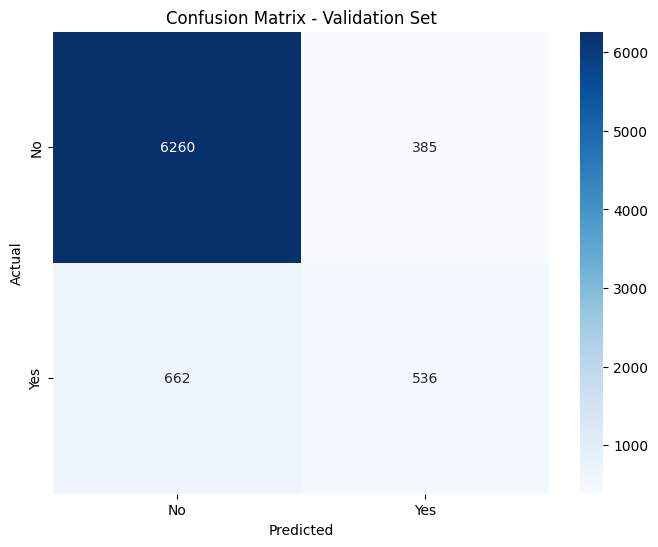


LightGBM Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      6645
           1       0.58      0.45      0.51      1198

    accuracy                           0.87      7843
   macro avg       0.74      0.69      0.71      7843
weighted avg       0.86      0.87      0.86      7843

Train F1 Score (macro): 0.8154
Train Accuracy: 0.9156
Validation F1 Score (macro): 0.7144


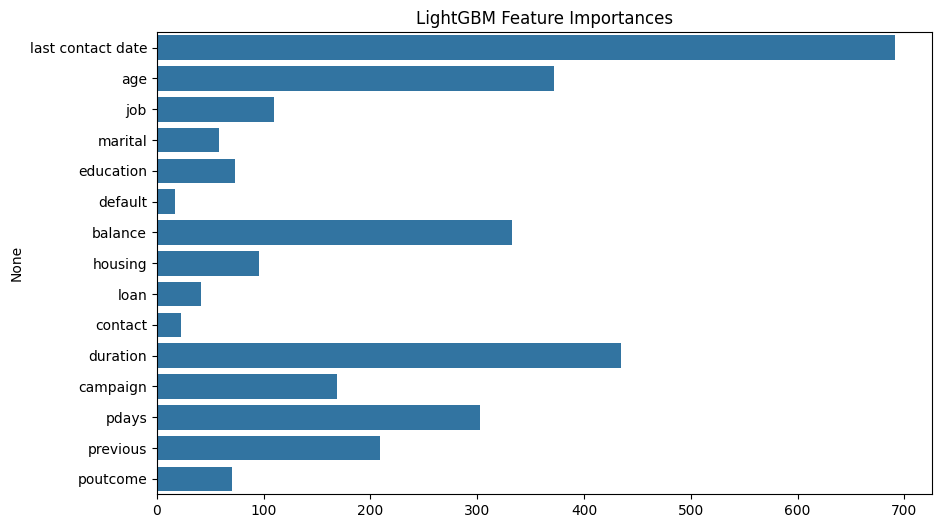

ValueError: could not convert string to float: '2009-11-21'

In [7]:
# Train LightGBM Model
lgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lgb', best_lgb_model)
])

lgb_pipeline.fit(X_train_split, y_train_split)

# Validation Metrics
y_val_pred = lgb_pipeline.predict(X_val_split)
print("\nLightGBM Classification Report on Validation Set:")
print(classification_report(y_val_split, y_val_pred))

# Predict on training data
y_train_pred = lgb_pipeline.predict(X_train_split)
y_train_pred_binary = (y_train_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Predict on validation data
y_val_pred = lgb_pipeline.predict(X_val_split)
y_val_pred_binary = (y_val_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Compute confusion matrix for validation predictions
conf_matrix = confusion_matrix(y_val_split, y_val_pred_binary)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Validation Set')
plt.show()

# Print classification metrics for validation
print("\nLightGBM Classification Report on Validation Set:")
print(classification_report(y_val_split, y_val_pred_binary))

# Compute metrics
train_f1 = f1_score(y_train_split, y_train_pred_binary, average='macro')
train_accuracy = accuracy_score(y_train_split, y_train_pred_binary)
validation_f1 = f1_score(y_val_split, y_val_pred_binary, average='macro')

# Print results
print(f"Train F1 Score (macro): {train_f1:.4f}")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Validation F1 Score (macro): {validation_f1:.4f}")

# Feature Importances
plt.figure(figsize=(10, 6))
sns.barplot(x=best_lgb_model.feature_importances_, y=X_train.columns)
plt.title("LightGBM Feature Importances")
plt.show()

# Predict on Test Data
y_test_pred = lgb_pipeline.predict(test)
submission = pd.DataFrame({'id': range(len(y_test_pred)), 'target': ['yes' if y == 1 else 'no' for y in y_test_pred]})
submission.to_csv('submission_lgb.csv', index=False)
